In [ ]:
!pip install ultralytics
!pip install pytesseract

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
!sudo apt-get update
!sudo apt-get install tesseract-ocr
!pip install pytesseract

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Ign:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,585 kB]

In [ ]:
import os
import cv2
import re
import pytesseract
from ultralytics import YOLO
import pandas as pd
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
ROOT_DIR = '/content/gdrive/MyDrive/05 KitaUsahakanMahkotaItu/NutriSmart'
IMAGE_DIR = os.path.join(ROOT_DIR, 'dataset/images/train')
model = YOLO(os.path.join(ROOT_DIR, 'best.pt'))

In [ ]:
def process_image(image_path):
    image = cv2.imread(image_path)
    results = model(image)
    boxes = results[0].boxes.xyxy

    nutrition_values = {}
    for box in boxes:
        cropped_image = crop_image(image, box)
        ocr_result = tesseract_ocr(cropped_image)
        values = extract_nutrition_values(ocr_result)
        nutrition_values.update(values)

    return nutrition_values

In [ ]:
def crop_image(image, box):
    x1, y1, x2, y2 = map(int, box)
    return image[y1:y2, x1:x2]

In [ ]:
def tesseract_ocr(image):
    custom_config = r'--oem 3 --psm 6'
    return pytesseract.image_to_string(image, config=custom_config)

In [ ]:
def extract_nutrition_values(text):
    # Initialize dictionary to store extracted values
    values = {}

    # Combine all lines into one text
    full_text = ' '.join(text.split('\n'))

    # Extract values using regex
    takaran_saji_match = re.search(r'Takaran Saji[: ]+(\d+)\s*ml', full_text, re.IGNORECASE)
    if takaran_saji_match:
        values['takaran-saji'] = takaran_saji_match.group(1)

    sajian_per_kemasan_match = re.search(r'Sajian Per Kemasan[: ]+(\d+)', full_text, re.IGNORECASE)
    if sajian_per_kemasan_match:
        values['sajian-per-kemasan'] = sajian_per_kemasan_match.group(1)

    gula_match = re.search(r'Gula[: ]+(\d+)\s*g', full_text, re.IGNORECASE)
    if gula_match:
        values['Gula'] = gula_match.group(1)

    garam_match = re.search(r'Garam\s*\(Natrium\)[: ]+(\d+)\s*mg', full_text, re.IGNORECASE)
    if garam_match:
        values['Garam'] = garam_match.group(1)

    # Capture "Lemak Total" or similar
    lemak_total_match = re.search(r'Lemak\s*Total[: ]+(\d+\.?\d*)\s*g', full_text, re.IGNORECASE)
    if lemak_total_match:
        values['Lemak'] = lemak_total_match.group(1)

    return values

In [ ]:
predictions = []
for filename in os.listdir(IMAGE_DIR):
    if filename.endswith('.jpg'):
        image_id = filename.split('.')[0]
        image_path = os.path.join(IMAGE_DIR, filename)
        nutrition_values = process_image(image_path)
        nutrition_values['Id'] = image_id
        predictions.append(nutrition_values)


0: 640x384 1 nutrition-table, 213.3ms
Speed: 7.6ms preprocess, 213.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x480 2 nutrition-tables, 194.4ms
Speed: 3.7ms preprocess, 194.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

0: 640x384 (no detections), 219.0ms
Speed: 4.0ms preprocess, 219.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 nutrition-table, 238.8ms
Speed: 4.2ms preprocess, 238.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 nutrition-table, 297.2ms
Speed: 5.8ms preprocess, 297.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 nutrition-table, 140.5ms
Speed: 4.4ms preprocess, 140.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 nutrition-table, 146.0ms
Speed: 5.3ms preprocess, 146.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 nutrition-tables, 230.2ms
Sp

In [ ]:
predictions_df = pd.DataFrame(predictions)
predictions_df.to_csv('predictions-pyt.csv', index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [ ]:
ground_truth = pd.read_csv('/content/drive/MyDrive/05 KitaUsahakanMahkotaItu/NutriSmart/dataset-mbdk.csv')
predictions = pd.read_csv('/content/predictions-pyt.csv')

In [ ]:
merged_df = pd.merge(ground_truth, predictions, on='Id', suffixes=('_true', '_pred'))

In [ ]:
components = ['takaran-saji', 'sajian-per-kemasan', 'Gula', 'Garam', 'Lemak']


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Id                       400 non-null    float64
 1   takaran-saji_true        400 non-null    float64
 2   sajian-per-kemasan_true  399 non-null    float64
 3   Gula_true                400 non-null    float64
 4   Garam_true               400 non-null    float64
 5   Lemak_true               400 non-null    object 
 6   Garam_pred               54 non-null     float64
 7   takaran-saji_pred        40 non-null     float64
 8   Lemak_pred               34 non-null     float64
 9   Gula_pred                25 non-null     float64
 10  sajian-per-kemasan_pred  14 non-null     float64
dtypes: float64(10), object(1)
memory usage: 34.5+ KB


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def evaluate_component(component):
    y_true = merged_df[f'{component}_true'].astype(str)
    y_pred = merged_df[f'{component}_pred'].astype(str)

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate accuracy
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)

    # Generate classification report
    report = classification_report(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {component}')
    plt.show()

    print(f"Evaluation for {component}:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Classification Report:\n{report}\n")


In [ ]:
def evaluate_component(component):
    y_true = merged_df[f'{component}_true'].astype(str)
    y_pred = merged_df[f'{component}_pred'].astype(str)

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate accuracy
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)

    # Generate classification report
    report = classification_report(y_true, y_pred)

    print(f"Evaluation for {component}:")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Classification Report:\n{report}\n")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

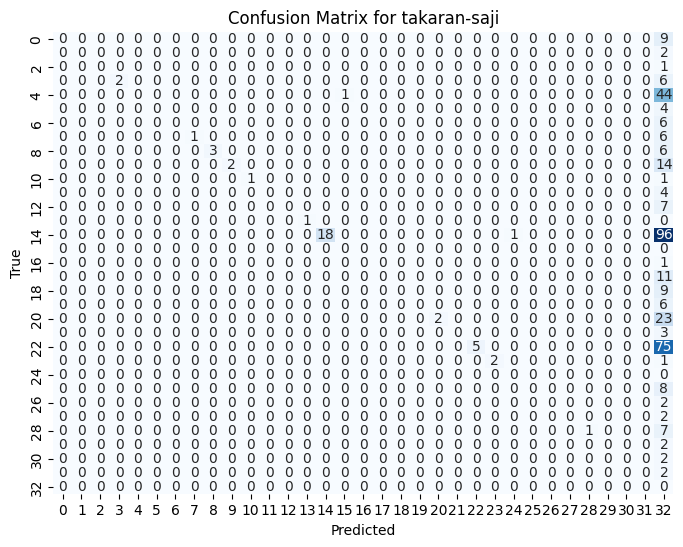

Evaluation for takaran-saji:
Accuracy: 0.10
Classification Report:
              precision    recall  f1-score   support

       100.0       0.00      0.00      0.00         9
       105.0       0.00      0.00      0.00         2
       110.0       0.00      0.00      0.00         1
       115.0       1.00      0.25      0.40         8
       125.0       0.00      0.00      0.00        45
       130.0       0.00      0.00      0.00         4
       140.0       0.00      0.00      0.00         6
       150.0       1.00      0.14      0.25         7
       175.0       1.00      0.33      0.50         9
       180.0       1.00      0.12      0.22        16
       185.0       1.00      0.50      0.67         2
       189.0       0.00      0.00      0.00         4
       190.0       0.00      0.00      0.00         7
       195.0       1.00      1.00      1.00         1
       200.0       1.00      0.16      0.27       115
      2125.0       0.00      0.00      0.00         0
       215.0  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

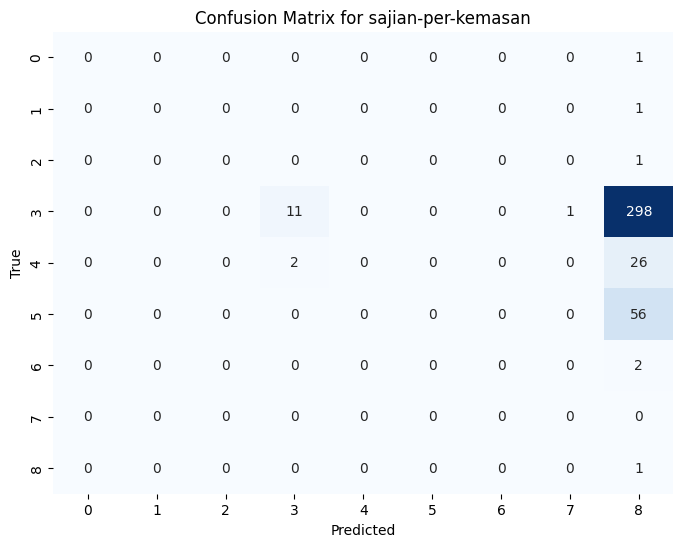

Evaluation for sajian-per-kemasan:
Accuracy: 0.03
Classification Report:
              precision    recall  f1-score   support

         0.5       0.00      0.00      0.00         1
         0.6       0.00      0.00      0.00         1
         0.8       0.00      0.00      0.00         1
         1.0       0.85      0.04      0.07       310
         1.5       0.00      0.00      0.00        28
         2.0       0.00      0.00      0.00        56
         2.5       0.00      0.00      0.00         2
         7.0       0.00      0.00      0.00         0
         nan       0.00      1.00      0.01         1

    accuracy                           0.03       400
   macro avg       0.09      0.12      0.01       400
weighted avg       0.66      0.03      0.05       400




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

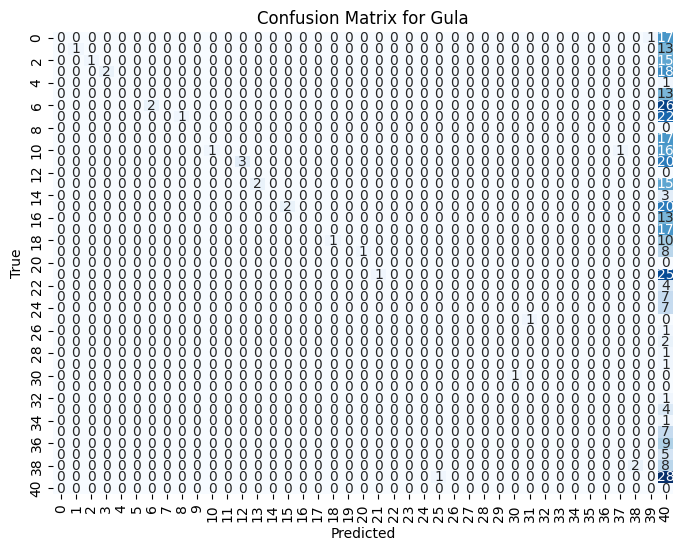

Evaluation for Gula:
Accuracy: 0.04
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        18
        10.0       1.00      0.07      0.13        14
        11.0       1.00      0.06      0.12        16
        12.0       1.00      0.10      0.18        20
       12.44       0.00      0.00      0.00         1
        13.0       0.00      0.00      0.00        13
        14.0       1.00      0.07      0.13        28
        15.0       0.00      0.00      0.00        23
       159.0       0.00      0.00      0.00         0
        16.0       0.00      0.00      0.00        17
        17.0       1.00      0.06      0.11        18
        18.0       0.00      0.00      0.00        23
       189.0       0.00      0.00      0.00         0
        19.0       1.00      0.12      0.21        17
         2.0       0.00      0.00      0.00         3
        20.0       1.00      0.09      0.17        22
        21.0       0.0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

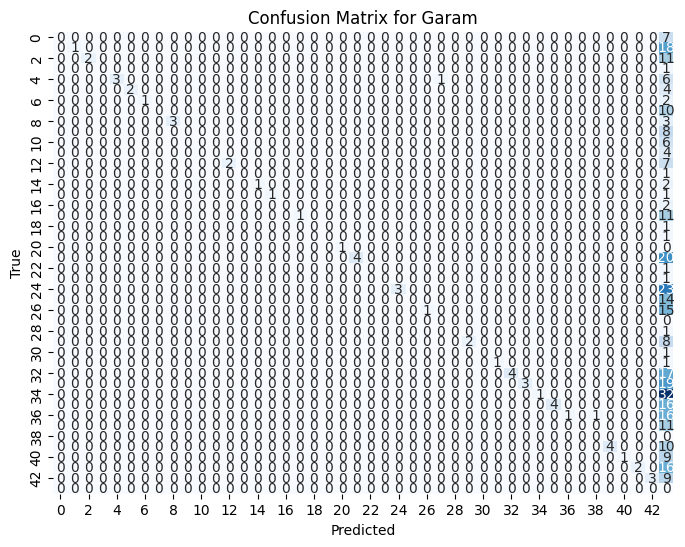

Evaluation for Garam:
Accuracy: 0.13
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
        10.0       1.00      0.05      0.10        19
       100.0       1.00      0.15      0.27        13
      101.66       0.00      0.00      0.00         1
       105.0       1.00      0.30      0.46        10
       110.0       1.00      0.33      0.50         6
       115.0       1.00      0.33      0.50         3
       120.0       0.00      0.00      0.00        10
       125.0       1.00      0.50      0.67         6
       130.0       0.00      0.00      0.00         8
       140.0       0.00      0.00      0.00         6
        15.0       0.00      0.00      0.00         4
       150.0       1.00      0.22      0.36         9
       160.0       0.00      0.00      0.00         1
       170.0       1.00      0.33      0.50         3
       180.0       1.00      0.50      0.67         2
       190.0       0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

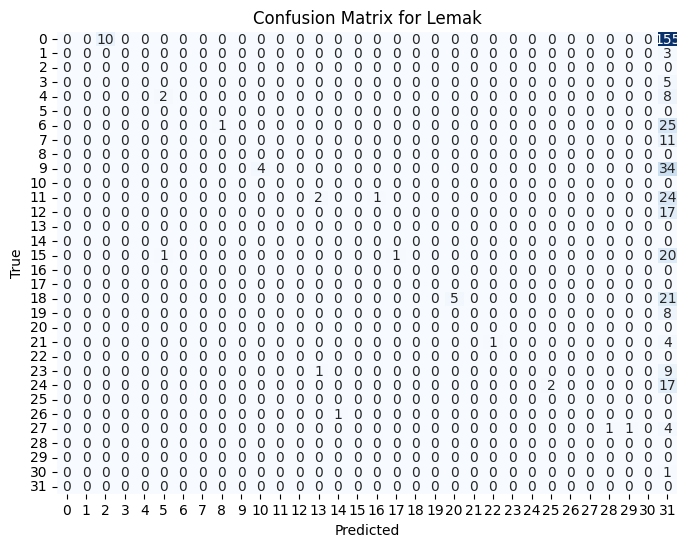

Evaluation for Lemak:
Accuracy: 0.00
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     165.0
         0,5       0.00      0.00      0.00       3.0
         0.0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       5.0
         1.5       0.00      0.00      0.00      10.0
        15.0       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00      26.0
         2,5       0.00      0.00      0.00      11.0
         2.0       0.00      0.00      0.00       0.0
         2.5       0.00      0.00      0.00      38.0
        25.0       0.00      0.00      0.00       0.0
           3       0.00      0.00      0.00      27.0
         3,5       0.00      0.00      0.00      17.0
         3.0       0.00      0.00      0.00       0.0
        3.05       0.00      0.00      0.00       0.0
         3.5       0.00      0.00      0.00      22.0
        30.0       0.

In [ ]:
for component in components:
    evaluate_component(component)